Network structure: Community organization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
np.random.seed(50)

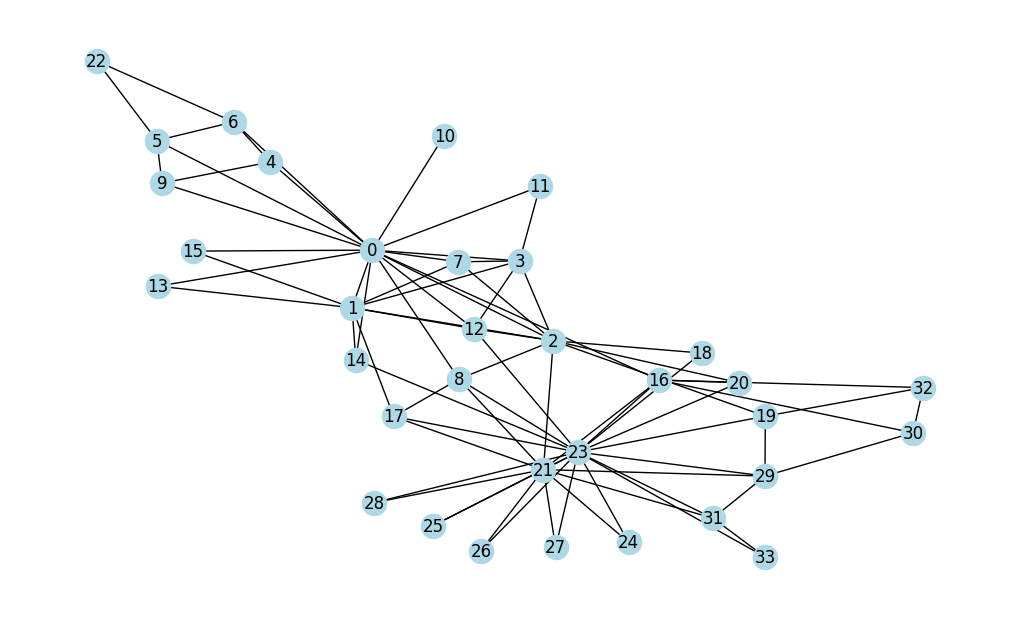

In [2]:
G= nx.read_edgelist("data/zachary.txt", nodetype=int)
nodes_original = G.nodes
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
G = nx.convert_node_labels_to_integers(G, first_label=0)

#G=nx.karate_club_graph() # we can also use the networkx dataset
pos=nx.spring_layout(G)
fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'lightblue', with_labels = True)
plt.show(True)

In [3]:
print('Original:', nodes_original)
print('New labels:', G.nodes)

Original: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31, 30, 9, 27, 28, 32, 16, 33, 14, 15, 18, 20, 22, 23, 25, 29, 24, 26]
New labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [4]:
N = len(G)
M = G.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

Number of nodes: 34
Number of edges: 78


Methdos for community identification

Method based on the betweenness centrality

In [5]:
#Girvan-Newman method (betweenness centrality)
communities = community.centrality.girvan_newman(G)
k = 2
for i in range(0, k-1):
    next_level_communities = next(communities)
c = sorted(map(sorted, next_level_communities))
for cl in c:
    print('community:', cl)

community: [0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 22]
community: [2, 8, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


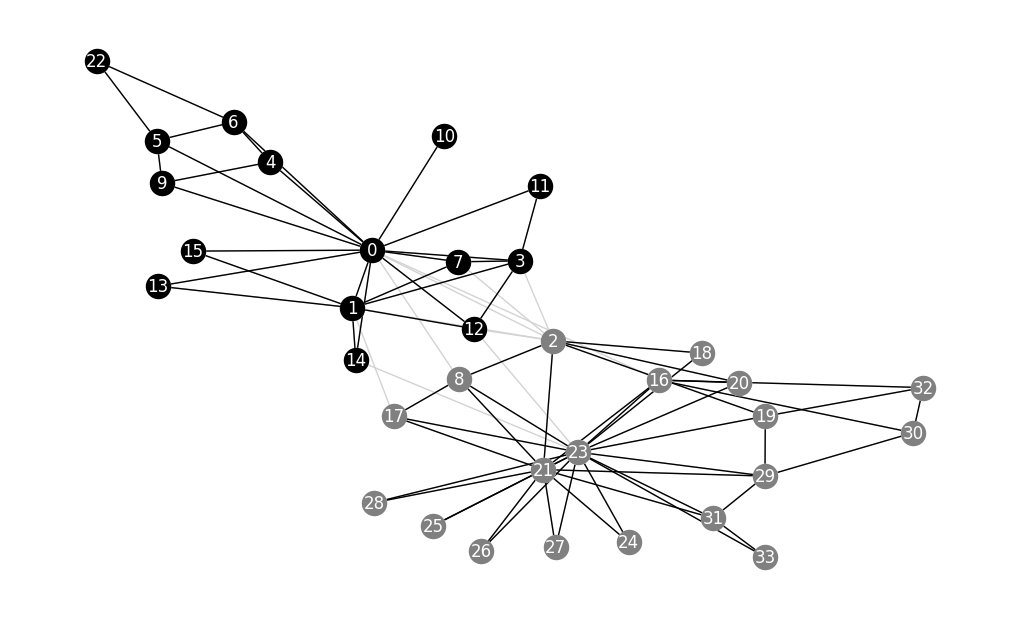

In [6]:
colors = ['black', 'gray', 'green', 'c', 'm', 'y', 'w']

fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'white', edge_color='lightgray')
aux = 0
for cm in c:
    nx.draw(G.subgraph(cm), pos=pos, node_color = colors[aux], 
                     with_labels = True, node_size=300, font_color = 'white')
    aux = aux + 1
plt.savefig('Zachary.eps') #save the figure into a file
plt.show(True)

<Figure size 640x480 with 0 Axes>

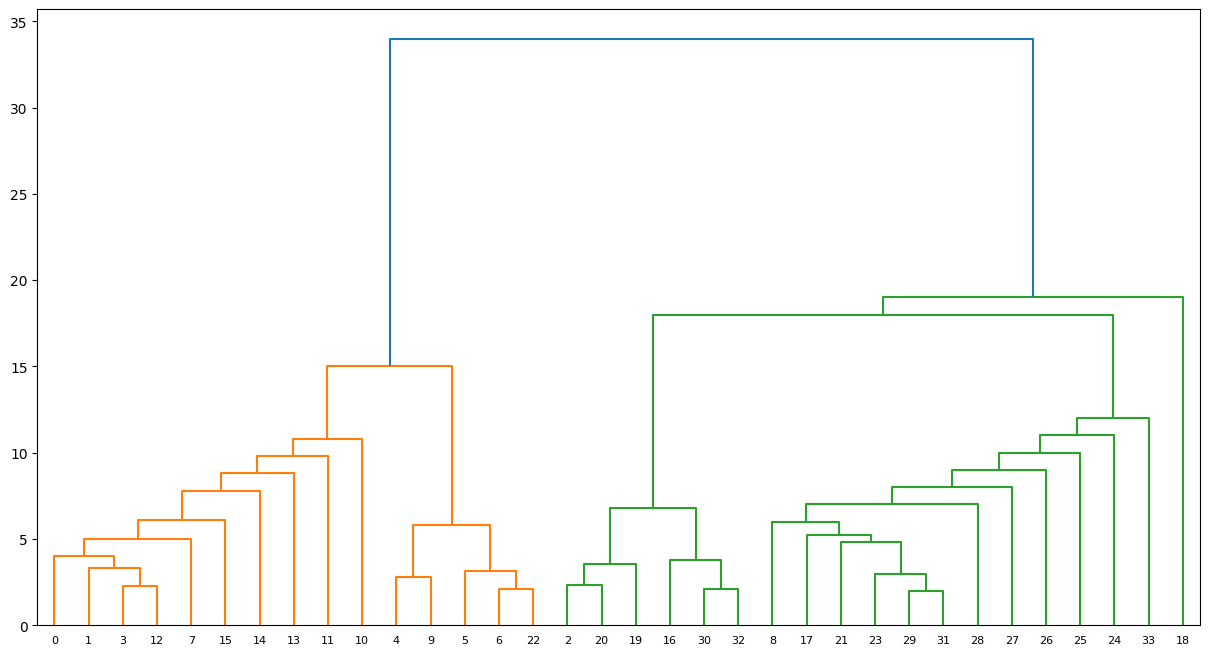

In [7]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

communities = list(community.centrality.girvan_newman(G))

# building initial dict of node_id to each possible subset:
node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

# turning this dictionary to the desired format 
node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

# recording node_labels dict for the correct label for dendrogram leaves
node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

# needing a subset to rank dict to later know within all k-length merges which came first
subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

# a function to get a merge height so that it is unique
def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

G           = nx.DiGraph(node_id_to_children)
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

# dendrogram
plt.figure()
fig= plt.figure(figsize=(15,8))
dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves], leaf_rotation=0)
plt.savefig('dendrogram.eps')

Fast greedy algorithm

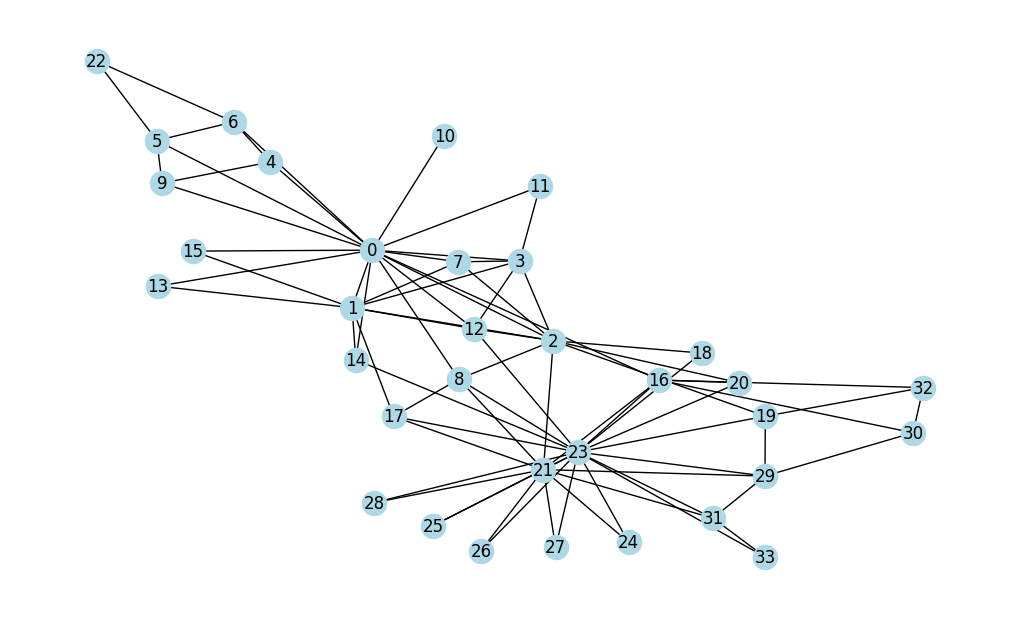

In [8]:
G= nx.read_edgelist("data/zachary.txt", nodetype=int)
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
G = nx.convert_node_labels_to_integers(G, first_label=0)


fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'lightblue', with_labels = True)
plt.show(True)

In [9]:
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G))
for k in range(0,len(communities)):
    print('Community',k,':', sorted(communities[k]))

Community 0 : [8, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Community 1 : [1, 2, 3, 7, 11, 12, 13, 15, 18]
Community 2 : [0, 4, 5, 6, 9, 10, 14, 22]


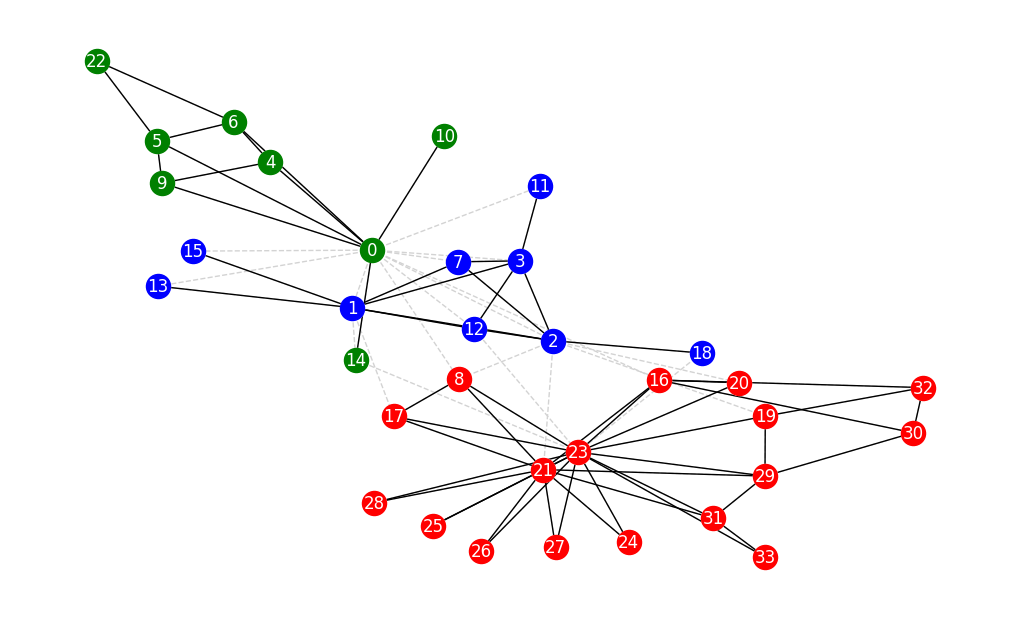

In [10]:
colors = ['red', 'blue', 'green', 'black', 'magenta', 'yellow', 'white']

fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'white', edge_color='lightgray', style='dashed')
aux = 0
for cm in communities:
    nx.draw(G.subgraph(cm), pos=pos, node_color = colors[aux], 
                     with_labels = True, node_size=300, font_color = 'white')
    aux = aux + 1
plt.savefig('Zachary.eps') #save the figure into a file
plt.show(True)

Louvain Method

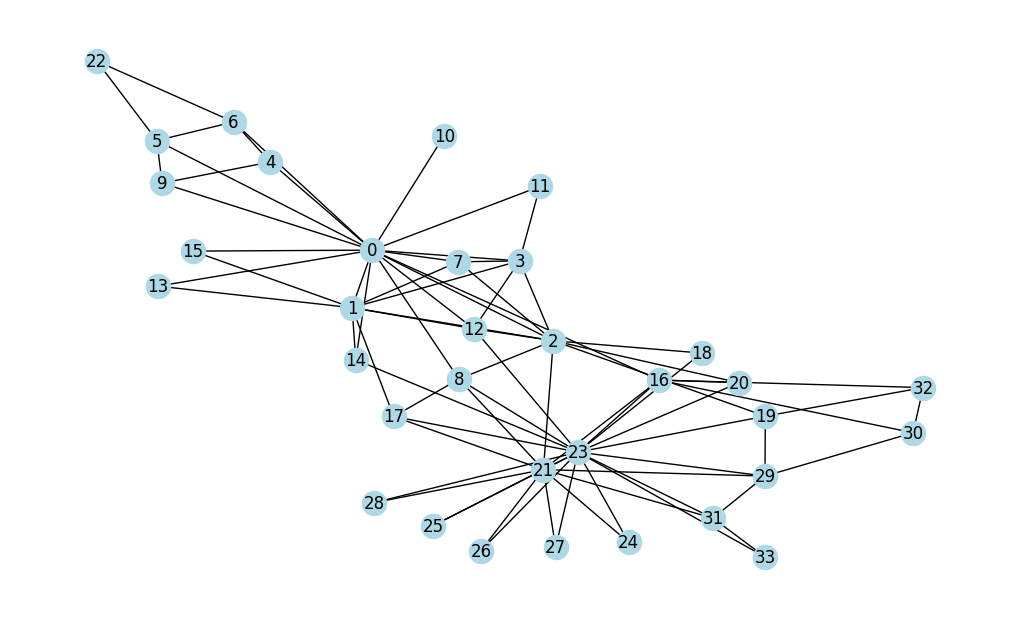

In [11]:
# To install, type in a terminal:
# pip install community
# pip install python-louvain

import community as community_louvain
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

G= nx.read_edgelist("data/zachary.txt", nodetype=int)
#G=nx.karate_club_graph() # we can also use the networkx dataset
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
G = nx.convert_node_labels_to_integers(G, first_label=0)

fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'lightblue',with_labels=True)
plt.show(True)

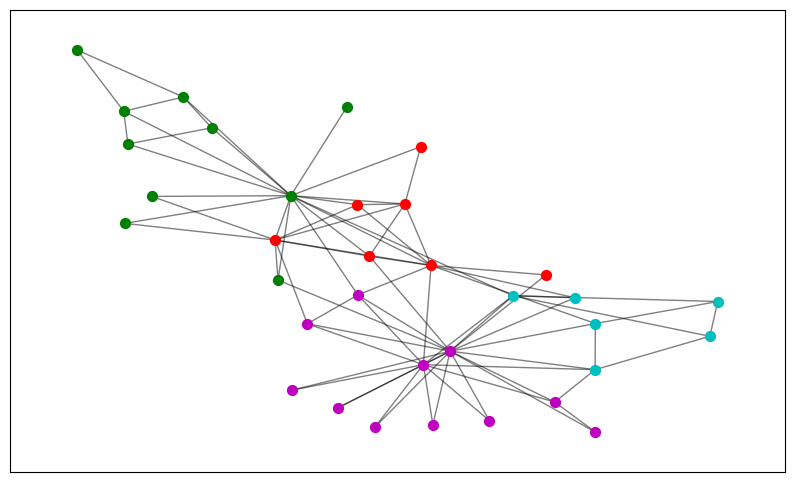

In [12]:
partitions =community_louvain.best_partition(G)
#drawing
fig= plt.figure(figsize=(10,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = float(len(set(partitions.values())))
count = 0
for com in set(partitions.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partitions.keys() if partitions[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

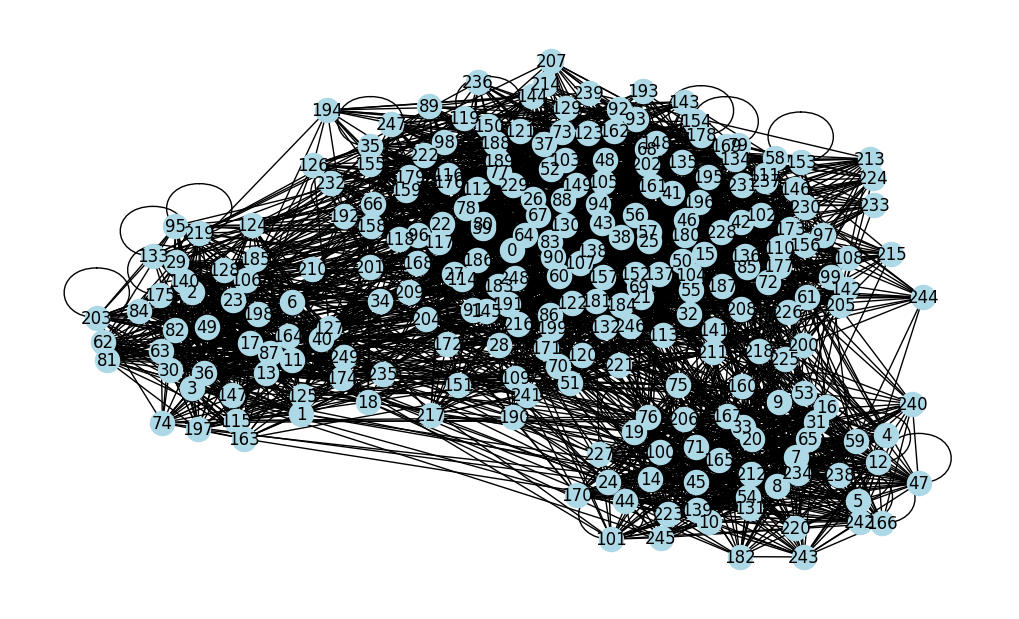

kin= 6.4


In [13]:
N = 250
tau1 = 2
tau2 = 2
mu = 0.1
k =16
minc = 20
maxc = 200
G = nx.LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                        max_degree = int(N*0.1), min_community=int(0.1*N), max_community = maxc, seed = 10)
pos=nx.spring_layout(G)
fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'lightblue', with_labels = True)
plt.show(True)
print('kin=', k*mu*4)

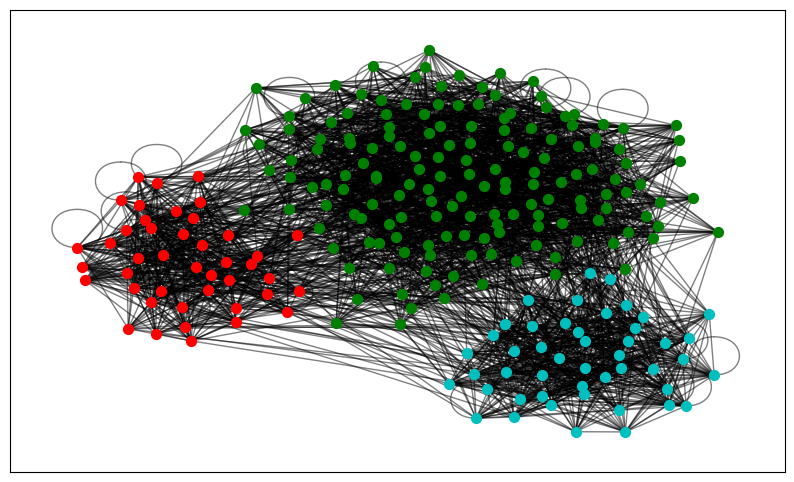

In [14]:
partition = community_louvain.best_partition(G)
#drawing
fig= plt.figure(figsize=(10,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = float(len(set(partition.values())))
count = 0
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

Modularity measure

In [15]:
from networkx.algorithms.community import greedy_modularity_communities

G=nx.karate_club_graph()

c = list(greedy_modularity_communities(G))
communities = np.zeros(len(G.nodes()))
nc = 0
for k in range(0,len(c)):
    communities[sorted(c[k])]=nc
    nc = nc+1
    print('Community:', sorted(c[k]))

Community: [8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Community: [1, 2, 3, 7, 9, 12, 13, 17, 21]
Community: [0, 4, 5, 6, 10, 11, 16, 19]


In [16]:
def modularity(G, c):
    A = nx.adjacency_matrix(G)
    N = len(G)
    M = G.number_of_edges()
    Q = 0
    for i in np.arange(0,N):
        ki = len(list(G.neighbors(i)))
        for j in np.arange(0,N):
            if(c[i]==c[j]):
                kj = len(list(G.neighbors(j)))
                Q = Q + A[i,j]-(ki*kj)/(2*M)
    Q = Q/(2*M)
    return Q

print("Modularity Q = ", modularity(G,communities))

Modularity Q =  1.9832347140039435


Communities in random network: Can we find them?

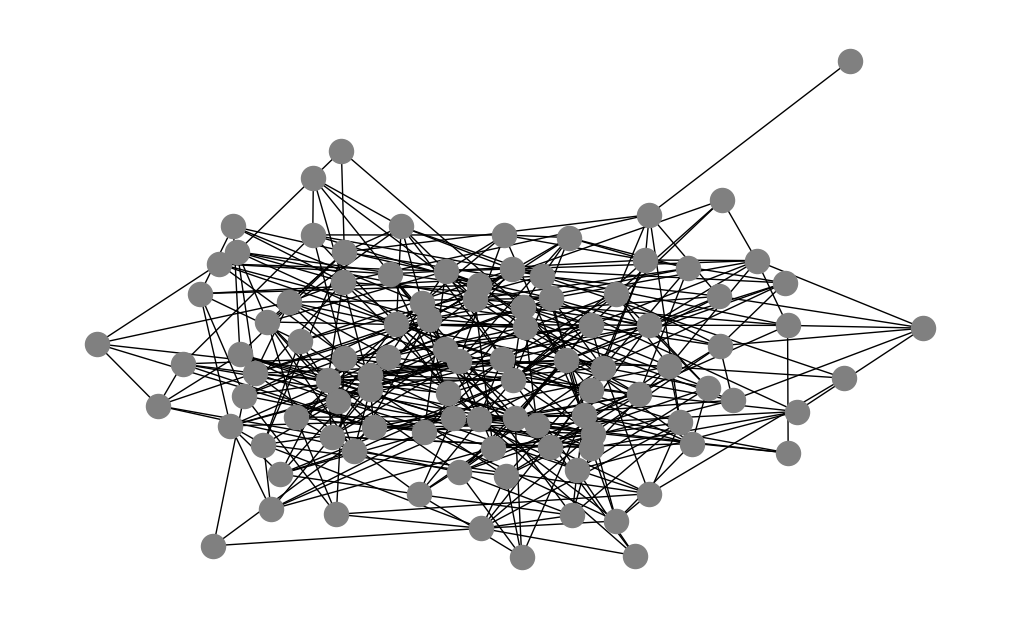

In [17]:
N = 100
av_degree = 8
p = av_degree/(N-1)
G = nx.gnp_random_graph(N, p, seed=None, directed=False)
pos=nx.fruchterman_reingold_layout(G)
fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'gray', with_labels=False)
plt.savefig('ER-com1.eps') #save the figure into a file
plt.show(True)

In [18]:
from networkx.algorithms.community import greedy_modularity_communities

c = list(greedy_modularity_communities(G))
communities = np.zeros(len(G.nodes()))
nc = 0
for k in range(0,len(c)):
    communities[sorted(c[k])]=nc
    nc = nc+1
    print('Community:', sorted(c[k]))

Community: [6, 9, 17, 21, 24, 30, 37, 40, 49, 52, 55, 58, 59, 72, 78, 93, 95]
Community: [7, 8, 11, 12, 25, 27, 31, 34, 38, 41, 51, 56, 57, 71, 74, 79, 99]
Community: [16, 18, 28, 29, 32, 36, 44, 46, 50, 60, 64, 65, 66, 81, 91, 92]
Community: [3, 13, 14, 19, 20, 39, 53, 54, 83, 84, 85, 89, 90, 96, 98]
Community: [1, 2, 4, 5, 23, 35, 42, 62, 67, 70, 73, 75, 86]
Community: [0, 10, 26, 33, 43, 45, 48, 63, 68, 76, 77, 80, 87]
Community: [15, 22, 47, 61, 69, 82, 88, 94, 97]


<Figure size 640x480 with 0 Axes>

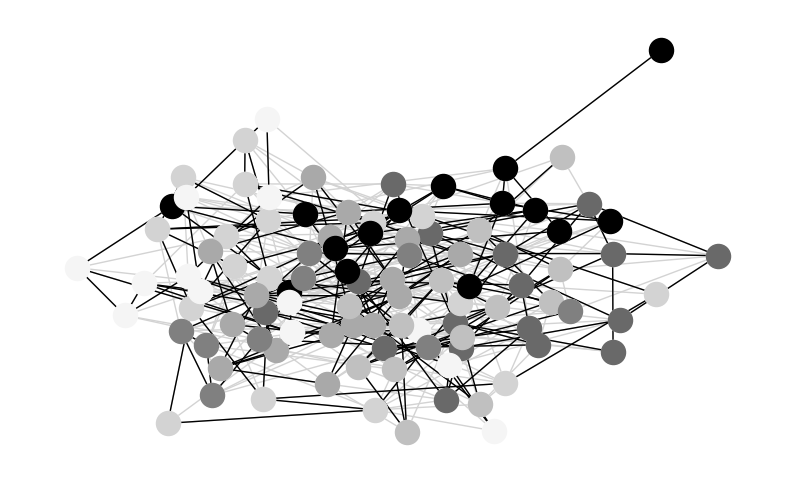

In [19]:
colors = ['dimgray', 'lightgray', 'darkgray', 'black', 'whitesmoke', 'silver','gray','grey']

plt.figure()
fig= plt.figure(figsize=(10,6))
nx.draw_networkx(G, pos=pos, node_color = 'white', edge_color='lightgray', with_labels = False)
aux = 0
for cm in c:
    nx.draw(G.subgraph(cm), pos=pos, node_color = colors[aux], 
                     with_labels = False, node_size=300, font_color = 'white')
    aux = aux + 1
plt.savefig('ER-com2.eps') #save the figure into a file
plt.show(True)

In [20]:
print("Modularity Q = ", modularity(G,communities))

Modularity Q =  0.2818073721759817


Benchmarks

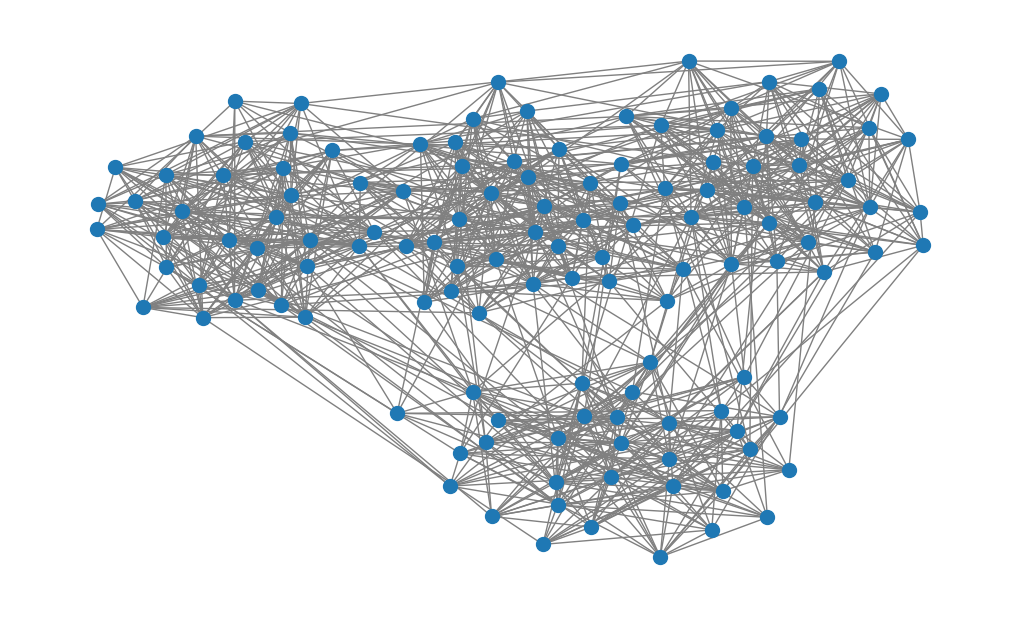

In [21]:
fig= plt.figure(figsize=(10,6))

k=16
kout = 3
kin = k - kout
pin = kin/32
pout = kout/(128-32)
G = nx.random_partition_graph([32,32,32,32],pin,pout)
pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, edge_color='gray', 
        node_size=100, font_size=16,  width=1, pos = pos)
plt.show(True)

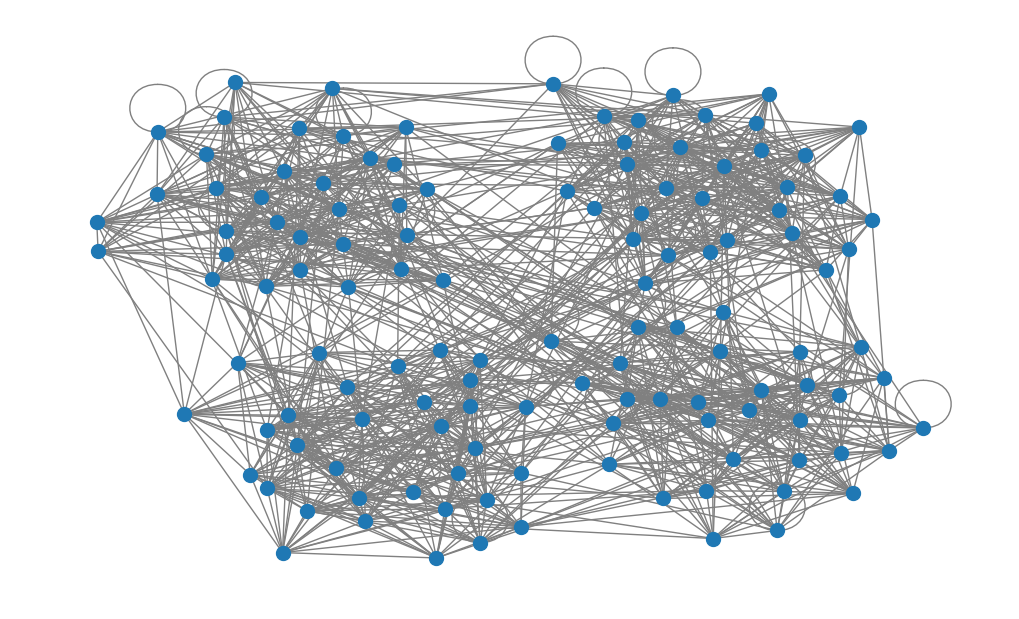

In [22]:
fig= plt.figure(figsize=(10,6))

N = 128
tau1 = 3
tau2 = 1.5
mu = 0.1
k =16
minc = 32
maxc = 32
G = nx.LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                        max_degree = k, min_community=minc, max_community = maxc, seed = 10)
pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, edge_color='gray', 
        node_size=100, font_size=16,  width=1, pos = pos)
plt.show(True)

In [23]:
c = {frozenset(G.nodes[v]['community']) for v in G}
communities = np.zeros(len(G.nodes()))
cl = 0
for a in c:
    b = list(a)
    communities[b] = cl
    #print(cl,':',sort(b))
    cl = cl + 1
print(communities)

[3. 2. 1. 3. 1. 0. 2. 2. 0. 0. 2. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 0.
 1. 2. 3. 3. 3. 1. 0. 2. 2. 1. 0. 3. 1. 2. 3. 2. 3. 1. 1. 3. 2. 2. 2. 0.
 2. 3. 3. 3. 2. 1. 0. 3. 3. 2. 0. 1. 2. 1. 2. 1. 2. 0. 2. 1. 0. 1. 3. 0.
 0. 2. 0. 0. 2. 0. 1. 3. 3. 0. 1. 3. 3. 2. 3. 3. 0. 0. 0. 0. 3. 0. 2. 3.
 1. 0. 0. 1. 1. 2. 3. 3. 0. 0. 3. 2. 1. 0. 2. 1. 1. 2. 0. 2. 0. 3. 2. 3.
 3. 3. 3. 2. 3. 0. 0. 1.]


In [24]:
print("Modularity Q = ", modularity(G,communities))

Modularity Q =  0.5427818606053953


In [25]:
#Girvan-Newman method (betweenness centrality)
communities = community.girvan_newman(G)
k = 4
for i in range(0, k-1):
    next_level_communities = next(communities)
c = sorted(map(sorted, next_level_communities))
for cl in c:
    print('community:', cl)

community: [0, 3, 26, 27, 28, 35, 38, 40, 43, 49, 50, 51, 55, 56, 70, 79, 80, 83, 84, 86, 87, 92, 95, 102, 103, 106, 117, 119, 120, 121, 122, 124]
community: [1, 6, 7, 10, 21, 22, 25, 31, 32, 37, 39, 44, 45, 46, 48, 52, 57, 60, 62, 64, 66, 73, 76, 85, 94, 101, 107, 110, 113, 115, 118, 123]
community: [2, 4, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 29, 33, 36, 41, 42, 53, 59, 61, 63, 67, 69, 78, 82, 96, 99, 100, 108, 111, 112, 127]
community: [5, 8, 9, 11, 23, 30, 34, 47, 54, 58, 65, 68, 71, 72, 74, 75, 77, 81, 88, 89, 90, 91, 93, 97, 98, 104, 105, 109, 114, 116, 125, 126]


<Figure size 1000x600 with 0 Axes>

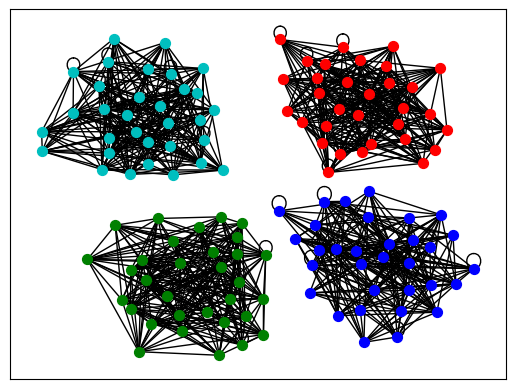

In [26]:
fig= plt.figure(figsize=(10,6))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure()
aux = 0
for cm in c:
    nx.draw_networkx(G.subgraph(cm), pos=pos, node_color = colors[aux], with_labels = False, node_size=50)
    aux = aux + 1
plt.show(True)